In [4]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score
from sklearn.model_selection import StratifiedKFold

In [5]:
# configure tqdm printing
#%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

In [6]:
features_df = pd.read_csv('extracted_features_files/_ecgiddb.csv')
test_features_df = pd.read_csv('extracted_features_files/_ecgiddb_original.csv')

#features_df.drop(['qrs_interval.1'], axis=1, inplace=True)
features_df.head()
#print(features_df['person'].value_counts())

,mean_q,mean_r,mean_s,stdev_q,stdev_r,stdev_s,mean_qrs_interval,mean_rr_interval,mean_rq_amplitude,person
0,-0.104878,0.695049,-0.163521,0.074419,0.033392,0.030779,406.25,0.799927,26.400000,person1
1,-0.270403,0.562847,-0.321890,0.126695,0.110208,0.169436,543.00,0.833250,28.250000,person1
2,-0.048579,0.712985,-0.116188,0.036970,0.072378,0.063060,365.25,0.761564,29.800000,person1
3,-0.476136,0.336879,-0.659080,0.000000,0.000000,0.000000,NaN,0.813015,30.000000,person1
4,-0.525585,0.381344,-0.567117,0.065124,0.085403,0.115455,729.50,0.906930,35.666667,person1


## Contagem de segmentos duplicados

In [7]:
#ecg_id_features.plot(figsize=(20,12))
print('total original:      ',len(features_df))
print('duplicados no original: ',sum(features_df.duplicated()))
print('número de pessoas únicas no original: ', features_df['person'].nunique())
features_df.drop_duplicates(keep='first', inplace=True)
print('total sem duplicados:      ',len(features_df))
print('duplicados no final: ',sum(features_df.duplicated()))
print('número de pessoas únicas sem dupicados: ', features_df['person'].nunique())

total original:       120
duplicados no original:  29
número de pessoas únicas no original:  1
total sem duplicados:       91
duplicados no final:  0
número de pessoas únicas sem dupicados:  1


In [5]:
def remove_outliers(original_dataset, lower_threshold, upper_threshold, column_names=[]):
    ''' Remove outliers from a dataframe
        Everything above or below these percentiles will be cut off
    '''
    # TODO: add treatment for not numerical columns
    dataset = original_dataset.copy()
    
    if column_names:
        for column in column_names:
            removed_outliers = remove(dataset[column], lower_threshold, upper_threshold)
            # save the indexes of rows that must be removed
            indexes_for_removal = dataset[column][~removed_outliers].index
            # in fact remove outliers from this column
            #print(indexes_for_removal)
            dataset.drop(indexes_for_removal, inplace=True)
            #print(f'removed {len(indexes_for_removal)} outliers for column {column}')
            #print(f'remaining itens in dataset: {len(dataset)}')
        return dataset
            
    else:
        column_names = list(dataset.columns)
        for column in column_names:
            removed_outliers = remove(dataset[column], lower_threshold, upper_threshold)
            # save the indexes of rows that must be removed
            indexes_for_removal = dataset[column][~removed_outliers].index
            # in fact remove outliers from this column 
            dataset.drop(indexes_for_removal, inplace=True)
        return dataset
    
def remove(series, lower_threshold, upper_threshold):
    ''' Remove outliers from a single pandas Series '''
    # create a boolean mask where False values are the outliers
    removed_outliers = series.between(series.quantile(lower_threshold),
                                      series.quantile(upper_threshold))
    return removed_outliers

In [6]:
lower_threshold = 0.0025 # 0,025%
upper_threshold = 0.9975 # 0,025%

#lower_threshold = 0.02 # 1%
#upper_threshold = 0.98 # 1%

column_names = list(features_df.columns)
person_index = column_names.index('person')
column_names.pop(person_index)
print(f'Original features had {len(features_df)} rows')

cleaned_features_df = remove_outliers(features_df,lower_threshold, upper_threshold, column_names=column_names)

print(f'Features without outliers has {len(cleaned_features_df)} rows')

#cleaned_features_df.to_csv('driver_db_cleaned_features.csv', index=False)

Original features had 6478 rows
Features without outliers has 5281 rows


In [7]:


# caso precisarmos de um label enconder
le = LabelEncoder()
cleaned_features_df['person'] = le.fit_transform(cleaned_features_df['person'])
#cleaned_features_df.dropna(inplace=True)
# Remove os rótulos


X = cleaned_features_df.drop(['person'], axis=1)
# Preenche os dados faltosos com a média da respectiva coluna
X = X.apply(lambda x: x.fillna(x.mean()))
# O objeto da predição é 'y' (os rótulos das classes)
y = cleaned_features_df['person']
X_train, _, y_train, _ = train_test_split(X, y, test_size = 0.2)


In [8]:
# pegando os dados de treino:
original_cleaned_features_df = remove_outliers(test_features_df,lower_threshold, upper_threshold, column_names=column_names)
#le = LabelEncoder()
original_cleaned_features_df['person'] = le.transform(original_cleaned_features_df['person'])
#cleaned_features_df.dropna(inplace=True)
# Remove os rótulos


X = original_cleaned_features_df.drop(['person'], axis=1)
# Preenche os dados faltosos com a média da respectiva coluna
X = X.apply(lambda x: x.fillna(x.mean()))
# O objeto da predição é 'y' (os rótulos das classes)
y = original_cleaned_features_df['person']
_, X_test, _, y_test = train_test_split(X, y, test_size = 0.2)

Text(0.5, 1.0, 'Cumulative distribution of number of examples')

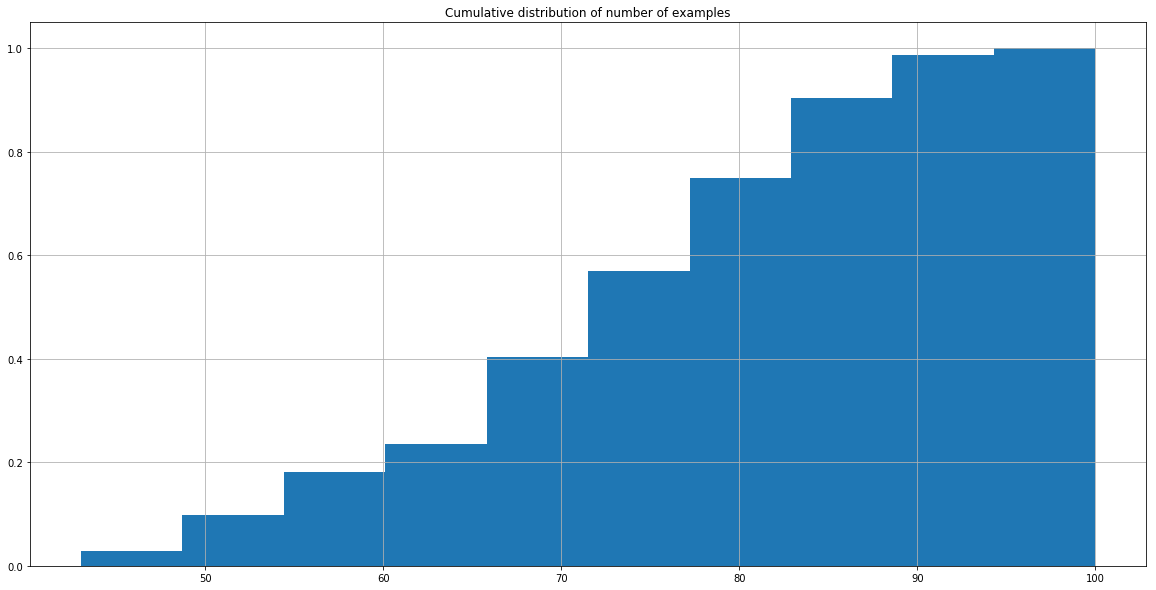

In [9]:
# filter_ = cleaned_features_df['person'].value_counts(ascending=True) >= 100
plt.figure(figsize=(20,10))

cleaned_features_df['person'].value_counts(ascending=True).hist(cumulative=True, density=1)
plt.title("Cumulative distribution of number of examples")

In [10]:
# se quisser obter as pessoas probleḿaticas
#print(list(cleaned_features_df['person'].value_counts(ascending=True)[:470].index))

In [11]:
# skf = StratifiedKFold(n_splits=10)
# skf.get_n_splits(X, y)
# print(skf)

# prediction_list = []

# for train_index, test_index in tqdm(skf.split(X, y)):
#     print(y[test_index])

In [12]:
rf = RandomForestClassifier(n_estimators=200, max_depth=100, min_samples_leaf=3, min_samples_split=10)
rf.fit(X_train, y_train)
predictions = rf.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         1
          15       0.00      0.00      0.00         0
          17       1.00      1.00      1.00         1
          18       1.00      1.00      1.00         1
          19       1.00      1.00      1.00         2
          23       1.00      1.00      1.00         1
          24       1.00      1.00      1.00         2
          25       1.00      1.00      1.00         1
          32       0.00      0.00      0.00         1
          36       1.00      1.00      1.00         1
          37       1.00    

/home/renato/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/renato/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [13]:
confusion_matrix(y_test, predictions)

array([[2, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 2, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [14]:
# skf = StratifiedKFold(n_splits=10)
# skf.get_n_splits(X, y)
# print(skf)

# prediction_list = []

# for train_index, test_index in tqdm(skf.split(X, y)):
#     #print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
#     rf = RandomForestClassifier(n_jobs=4, n_estimators=200, max_depth=100, min_samples_leaf=3, min_samples_split=10, verbose=True)
#     rf.fit(X_train, y_train)
#     predictions = rf.predict(X_test)
#     classification_output = classification_report(y_test, predictions)
#     #print(classification_output)
#     prediction_list.append(classification_output)
    
# print(prediction_list[0])

In [3]:
import pandas as pd
import numpy as np
df = pd.DataFrame([[1.0, 2.0, 3.0],
                  [2.0, 3.0, 4.0],
                  [3.0, 4.0, 5.0],
                  [4.0, 5.0, 6.0],
                  [5.0, 6.0, 7.0],
                  [5.0, 6.0, 2.0],
                  [5.0, 6.0, 2.0]]
                  )



df2 = pd.DataFrame([[1.0000001, 2.0000010, 3.0000001],
                  [1.0, 5.0, 2.0],
                  [9.0, 9.0, 9.0],
                  [8.0, 8.0, 8.0],
                  [6.0, 6.0, 7.0],
                  [5.0, 6.15, 5.0],
                  [5.0, 1.00001, 2.0]]
                  )
# skf = StratifiedKFold(n_splits=2)
# skf.get_n_splits(X, y)
# print(skf)


# df.columns = ["oi", "ola", "alo", "ei"]

# df.head()
#print('duplicados no original: ',sum(df.duplicated()))
print('antigo len: ',len(df))
extracted_features= np.array(["a", 4.0, 5.0])
df.loc[len(df)] = extracted_features
print('novo len: ', len(df))
#print(type(extracted_features[0]))
#print(type(df.iloc[0][0]))
#((df==np.array(extracted_features)).all(1).any())

df = pd.concat([df, df2], ignore_index=True)
print(df)
teste = np.array([1, 2, 3])
print((df == teste).all(1).any())

antigo len:  7
novo len:  8
    0        1    2
0   1        2    3
1   2        3    4
2   3        4    5
3   4        5    6
4   5        6    7
5   5        6    2
6   5        6    2
7   a      4.0  5.0
8   1        2    3
9   1        5    2
10  9        9    9
11  8        8    8
12  6        6    7
13  5     6.15    5
14  5  1.00001    2
True
